# VinBigData Chest X-ray Abnormalities Detectionm

### Automatically localize and classify thoracic abnormalities from chest radiographsm

Page:
https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection

# Import Packages

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import pathlib
from pprint import pprint

#img
import cv2

#pytorch
import torch
from torch import nn
from torch import functional as F
from torch import optim
from torch.utils.data import Dataset,DataLoader,random_split
from torchvision import transforms
from torch.nn import Module
from torchvision import models
from PIL import Image
#dicom
import pydicom

In [27]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.notebook import tqdm
import albumentations as A


#set Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [28]:
#-----path-----
#train csv
train_csv_path=pathlib.\
        Path("../input/vinbigdata-chest-xray-abnormalities-detection/train.csv")
sample_sub_path=pathlib.\
        Path("../input/vinbigdata-chest-xray-abnormalities-detection/sample_submission.csv")
#dicom data
train_data_path=pathlib.\
        Path("../input/vinbigdata-chest-xray-abnormalities-detection/train")
test_data_path=pathlib.\
        Path("../input/vinbigdata-chest-xray-abnormalities-detection/test")

In [29]:
#trainデータのindexリストを取得する。
image_ids=[x for x in train_data_path.iterdir() if x.is_file()]
len(image_ids)

15000

# DataFrame : Train Data

In [30]:
#train csv
df=pd.read_csv(train_csv_path)
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [31]:
#image id部分のみを分割
sample_=pathlib.\
    Path('../input/vinbigdata-chest-xray-abnormalities-detection/train/000434271f63a053c4128a0ba6352c7f.dicom')
#拡張子のみを取得する
print("拡張子；",image_ids[0].suffix)
#拡張子なしのidのみを取得
print("拡張子なしのファイル名取得:",image_ids[0].stem)

拡張子； .dicom
拡張子なしのファイル名取得: 4d390e07733ba06e5ff07412f09c0a92


In [32]:
#bounding boxを取得することは可能。
df[df["image_id"]==sample_.stem]

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
689,000434271f63a053c4128a0ba6352c7f,No finding,14,R6,NaN,NaN,NaN,NaN
56742,000434271f63a053c4128a0ba6352c7f,No finding,14,R2,NaN,NaN,NaN,NaN
65515,000434271f63a053c4128a0ba6352c7f,No finding,14,R3,NaN,NaN,NaN,NaN


# dataframeの欠損値を修正


## 1. class Name: No finding はデータなしに該当

>0 - Aortic enlargement
1 - Atelectasis
2 - Calcification
3 - Cardiomegaly
4 - Consolidation
5 - ILD
6 - Infiltration
7 - Lung Opacity
8 - Nodule/Mass
9 - Other lesion
10 - Pleural effusion
11 - Pleural thickening
12 - Pneumothorax
13 - Pulmonary fibrosis

### No_findingに該当するには14に指定


#### columns;x_min	y_min	x_max	y_maxはNaNになっているため欠損値補完が必要




In [33]:
df.isnull().sum()
#上記意外に欠損値はなさそう。

image_id          0
class_name        0
class_id          0
rad_id            0
x_min         31818
y_min         31818
x_max         31818
y_max         31818
dtype: int64

In [34]:
#bounding boxがない場合Nanとなっているため、穴埋め 
df.fillna(0,inplace=True)

In [35]:
#classid
"""
>0 - Aortic enlargement
1 - Atelectasis
2 - Calcification
3 - Cardiomegaly
4 - Consolidation
5 - ILD
6 - Infiltration
7 - Lung Opacity
8 - Nodule/Mass
9 - Other lesion
10 - Pleural effusion
11 - Pleural thickening
12 - Pneumothorax
13 - Pulmonary fibrosis
"""

df["class_id"].unique()

array([14,  3,  0, 11,  5,  8, 13,  7,  1,  9,  6, 10,  2,  4, 12])

# Plot Sample Image

In [36]:
# dicomデータの画像表示
sample_ids=image_ids[10]
print(sample_ids.stem)
print(sample_ids.suffix)

98617a2bbd11c4afa7be664889cdd6de
.dicom


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 158
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 98617a2bbd11c4afa7be664889cdd6de
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '049Y'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 2861
(0028, 0011) Columns                             US: 2619
(0028, 0100) Bits Allocate

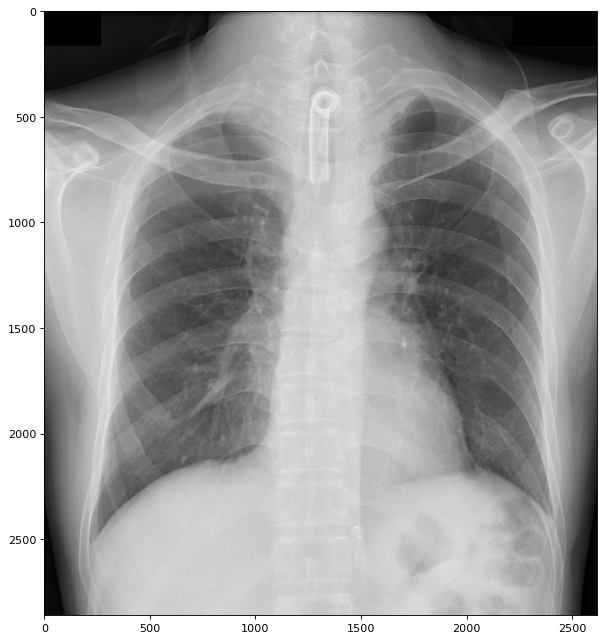

In [48]:
# Read Dicom Data
sample_dicom=pydicom.dcmread(sample_ids)
print(sample_dicom)

#plt dicom image
samp_img=sample_dicom.pixel_array
print(samp_img.shape)
plt.figure(num=None, figsize=(10, 10), dpi=80, )
plt.imshow(samp_img,cmap="gray")
plt.show()

In [49]:
#dfよりtrainの情報を取得する。
sample_data=df[df["image_id"]==sample_ids.stem]
sample_data

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
21851,98617a2bbd11c4afa7be664889cdd6de,Lung Opacity,7,R9,655.0,368.0,1178.0,708.0
25349,98617a2bbd11c4afa7be664889cdd6de,Pleural thickening,11,R8,915.0,403.0,1220.0,777.0
28931,98617a2bbd11c4afa7be664889cdd6de,Nodule/Mass,8,R10,2240.0,1657.0,2312.0,1738.0
39495,98617a2bbd11c4afa7be664889cdd6de,Pulmonary fibrosis,13,R9,694.0,1669.0,935.0,1916.0
43174,98617a2bbd11c4afa7be664889cdd6de,Pleural thickening,11,R9,1510.0,352.0,2119.0,675.0
47769,98617a2bbd11c4afa7be664889cdd6de,Lung Opacity,7,R9,1510.0,352.0,2119.0,675.0
56177,98617a2bbd11c4afa7be664889cdd6de,Pleural thickening,11,R9,655.0,368.0,1178.0,708.0
62339,98617a2bbd11c4afa7be664889cdd6de,Nodule/Mass,8,R10,673.0,577.0,758.0,655.0
63544,98617a2bbd11c4afa7be664889cdd6de,Pleural thickening,11,R8,1496.0,362.0,1755.0,809.0


In [50]:
# Define Plot Image and BoundingBox
def drawBBox(img_id, df):
    image_path = str(train_data_path / img_id) + '.dicom'
    img = pydicom.dcmread(image_path)
    img = img.pixel_array
    print("Dicom Image Shape:",img.shape)
    dh, dw, = img.shape

    for index, row in df.iterrows():
        class_name = row['class_name']
        l = int(row['x_min'])
        r = int(row['x_max'])
        t = int(row['y_min'])
        b = int(row['y_max'])
        color = (0,0,255)
        
        #labelを付与
        cv2.putText(img, class_name, (l, t), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)
        #cv2.rectangleのtuppleにはintを入力する(floatは不可)
        cv2.rectangle(img, (l, t), (r, b), (255,0,0), 2)

    plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(img,cmap="bone")
    plt.show()

In [51]:
#sampleを出力する。
image_id="98617a2bbd11c4afa7be664889cdd6de"
test_df=df[df["image_id"]==image_id]
test_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
21851,98617a2bbd11c4afa7be664889cdd6de,Lung Opacity,7,R9,655.0,368.0,1178.0,708.0
25349,98617a2bbd11c4afa7be664889cdd6de,Pleural thickening,11,R8,915.0,403.0,1220.0,777.0
28931,98617a2bbd11c4afa7be664889cdd6de,Nodule/Mass,8,R10,2240.0,1657.0,2312.0,1738.0
39495,98617a2bbd11c4afa7be664889cdd6de,Pulmonary fibrosis,13,R9,694.0,1669.0,935.0,1916.0
43174,98617a2bbd11c4afa7be664889cdd6de,Pleural thickening,11,R9,1510.0,352.0,2119.0,675.0
47769,98617a2bbd11c4afa7be664889cdd6de,Lung Opacity,7,R9,1510.0,352.0,2119.0,675.0
56177,98617a2bbd11c4afa7be664889cdd6de,Pleural thickening,11,R9,655.0,368.0,1178.0,708.0
62339,98617a2bbd11c4afa7be664889cdd6de,Nodule/Mass,8,R10,673.0,577.0,758.0,655.0
63544,98617a2bbd11c4afa7be664889cdd6de,Pleural thickening,11,R8,1496.0,362.0,1755.0,809.0


Dicom Image Shape: (2861, 2619)


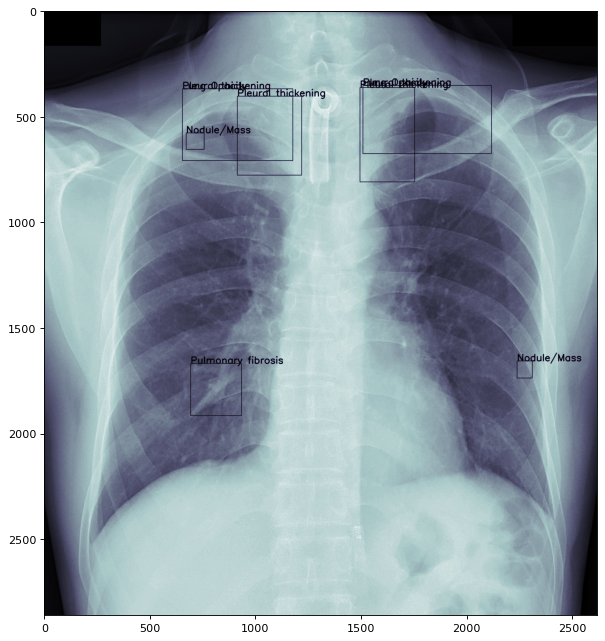

In [52]:
#plot dicom image
drawBBox(image_id, test_df,)